# Analysis of House Prices in Ames, IA
### Regularized Regression, Cross-Validation, and Feature Selection
##### Grant Nikseresht, Yuqing Zhao, Yue Ning

This notebook is a glimpse into the R workflow that Yuqing, Yue, and myself (Grant) used in analyzing the [Ames, IA housing dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) featured on Kaggle. Our analysis was done as part of our final project for Applied Stats (MATH 564) at IIT. 

The goal of the Kaggle challenge was to predict the selling price of a home given a number of its attributes. Selecting which features to use in our model was the primary challenge in analyzing this dataset, where many of the features are collinear, trivial, or uncorrelated with the dependent variable. 

For our course project, we decided to compare different methods for feature selection including manual selection, stepwise regression, and regularized regression. In this notebook, we'll explore the dataset, implement several regression methods with cross-validation, and compare some results. 


In [3]:
library(rpart)
library(caret)
library(leaps)
library(glmnet)
library(ggplot2)
library(tabplot)
library(reshape2)
options(warn=-1) 

ERROR: Error in library(rpart): there is no package called ‘rpart’


## Exploring the Data

We performed some preprocessing of the original Kaggle data and stored it in a file in the `data` folder. Let's load it into a dataframe and pull the index out to prepare it for analysis.

In [6]:
train_df <- read.csv("./data/train_processed.csv")
train_df <- train_df[,-c(1)]

Our processed dataset now contains 1457 observations and 51 explanatory variables. All missing and nonsensical values have been removed. Let's take a look at the data using some handy R functions.

In [7]:
dim(train_df)
summary(train_df)

[1] 1457   51

   MSSubClass        MSZoning        Alley      LotShape  LandContour
 Min.   : 20.00   C (all):  14   Grvl   :  50   IR1:482   Bnk:  61   
 1st Qu.: 20.00   FV     :  65   NoAlley:1366   IR2: 41   HLS:  50   
 Median : 50.00   RH     :  16   Pave   :  41   IR3:  9   Low:  36   
 Mean   : 56.89   RL     :1144                  Reg:925   Lvl:1310   
 3rd Qu.: 70.00   RM     : 218                                       
 Max.   :190.00                                                      
                                                                     
   LotConfig    LandSlope   Neighborhood   Condition1     BldgType   
 Corner : 261   Gtl:1379   NAmes  :225   Norm   :1259   1Fam  :1217  
 CulDSac:  94   Mod:  65   CollgCr:150   Feedr  :  80   2fmCon:  31  
 FR2    :  47   Sev:  13   OldTown:113   Artery :  48   Duplex:  52  
 FR3    :   4              Edwards: 98   RRAn   :  26   Twnhs :  43  
 Inside :1051              Somerst: 86   PosN   :  18   TwnhsE: 114  
                    

Let's take a quick visual glimpse at the distribution of the log of selling price. We use both the built in R functions like `boxplot` and the more extensive plotting package `ggplot2`. 

ERROR: Error in ggplot(data = train_df, aes(train_df$SalePrice)): could not find function "ggplot"


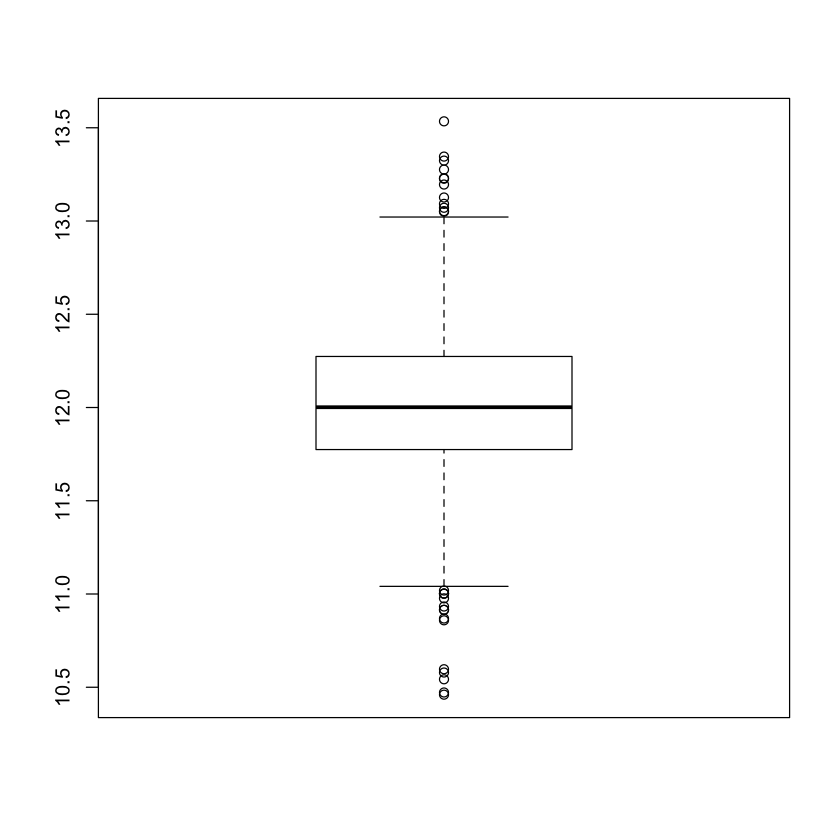

In [12]:
boxplot(train_df$SalePrice)
ggplot(data=train_df, aes(train_df$SalePrice)) + 
  geom_histogram (col="red", aes(fill=..count..)) +
  scale_fill_gradient("Count", low = "green", high = "red")+
  labs(title="Histogram for SalePrice") +
  labs(x="SalePrice", y="Count")+
  theme(plot.title = element_text(hjust = 0.5))

Let's take a 10,000 foot view of the explanatory variables as well using `tabplot`. A few are shown below, but feel free to try this on other variables. This view proves useful for visualizing how homoegenous or incomplete a dataset is.

In [13]:
tabplot(train_df[,30:34])
tabplot(train_df[,41:45])
tabplot(train_df[,5:9])

ERROR: Error in tabplot(train_df[, 30:34]): could not find function "tabplot"


Here's an example of an issue in the data that required some preprocessing. Each component of the house generally had a few associated explanatory variables. For instance, there are several variables each providing similar information about basements and garages. The `xtabs` function below shows a contingency table to estimate the amount of collinearity between factor variables. 

In [4]:
xtabs(~GarageQual+GarageCond+GarageFinish, data=train_df)
xtabs(~BsmtCond+BsmtFinType1, data=train_df)

, , GarageFinish = Fin

          GarageCond
GarageQual  Ex  Fa  Gd NoGarage  Po  TA
  Ex         1   0   0        0   0   0
  Fa         0   0   0        0   0   1
  Gd         0   0   1        0   0   1
  NoGarage   0   0   0        0   0   0
  Po         0   0   0        0   0   0
  TA         0   1   0        0   0 344

, , GarageFinish = NoGarage

          GarageCond
GarageQual  Ex  Fa  Gd NoGarage  Po  TA
  Ex         0   0   0        0   0   0
  Fa         0   0   0        0   0   0
  Gd         0   0   0        0   0   0
  NoGarage   0   0   0       81   0   0
  Po         0   0   0        0   0   0
  TA         0   0   0        0   0   0

, , GarageFinish = RFn

          GarageCond
GarageQual  Ex  Fa  Gd NoGarage  Po  TA
  Ex         0   0   0        0   0   0
  Fa         0   0   0        0   0   0
  Gd         0   0   2        0   0   5
  NoGarage   0   0   0        0   0   0
  Po         0   0   0        0   0   0
  TA         0   0   3        0   0 412

, , GarageFinish 

        BsmtFinType1
BsmtCond ALQ BLQ GLQ LwQ  No Rec Unf
      Fa   1   3   0   8   0   8  25
      Gd  12   3  26   5   0   3  16
      No   0   0   0   0  37   0   0
      Po   0   1   0   0   0   0   1
      TA 207 141 389  61   0 122 388

Perfectly collinear or homogenous variables leading can sabotage regression variables, so we're only going to keep one of the variables for garage and one for basement. 

In [5]:
train_df <- train_df[, -c(which(colnames(train_df) == "GarageFinish"),
                            which(colnames(train_df) == "Exterior2nd"),
                            which(colnames(train_df) == "GarageCond"),
                            which(colnames(train_df) == "BsmtFinType1"))]
dim(train_df)

[1] 1457   47

Here's a function we'll use at the end to compute our error. We're using root mean squared logarithmic error (RMSLE) to compare models. We've already log transformed our dependent variable, so this is basically just RMSE.

$RMSLE = \sqrt{(\frac{1}{n}\sum_{i=1}^n(\hat{Y} - Y)^2)}$

In [6]:
rmsle <- function(yhat, y) {
  n <- length(yhat)
  return(sqrt((1/n)*sum((yhat-y)^2)))
}

## Analysis

Since the only labeled data we have access to is the training set, we're going to use cross-validation to estimate how well our model will generalize to new data. 

For this, we're going to use the `caret` package, which provides an interface for cross-validating models on a variety of methods. A control parameter is initialized below that will tell future calls to `caret` what settings to use for performing cross-validation. All we have to do here is set the number of folds to 10.

In [14]:
set.seed(564)
controlParameter <- trainControl(method = "cv",
                                  number = 10,
                                  savePredictions = TRUE)

ERROR: Error in trainControl(method = "cv", number = 10, savePredictions = TRUE): could not find function "trainControl"


In [10]:
lm_ols <- train(SalePrice~.,
                data = train_df,
                method='lm',
                trControl=controlParameter)
ols_fit <- lm_ols$finalModel


Call:
lm(formula = .outcome ~ ., data = dat)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.65983 -0.04741  0.00171  0.05191  0.52903 

Coefficients: (2 not defined because of singularities)
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           8.708e+00  5.380e-01  16.185  < 2e-16 ***
MSSubClass           -4.020e-04  3.670e-04  -1.095 0.273605    
MSZoningFV            2.633e-01  4.590e-02   5.738 1.20e-08 ***
MSZoningRH            2.564e-01  4.502e-02   5.695 1.54e-08 ***
MSZoningRL            2.439e-01  3.461e-02   7.046 3.00e-12 ***
MSZoningRM            2.180e-01  3.392e-02   6.428 1.82e-10 ***
AlleyNoAlley         -1.674e-02  1.907e-02  -0.878 0.380099    
AlleyPave             2.184e-03  2.733e-02   0.080 0.936327    
LotShapeIR2           3.808e-02  1.871e-02   2.035 0.042047 *  
LotShapeIR3           7.023e-02  3.820e-02   1.839 0.066206 .  
LotShapeReg           2.695e-03  7.196e-03   0.375 0.708083    
LandContourHLS        8.98

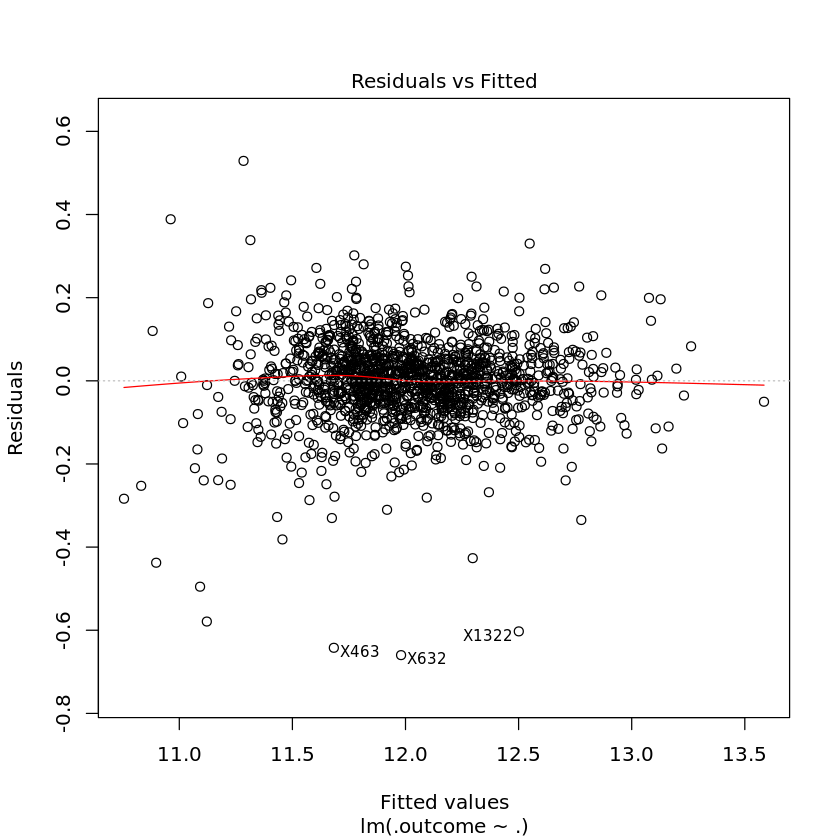

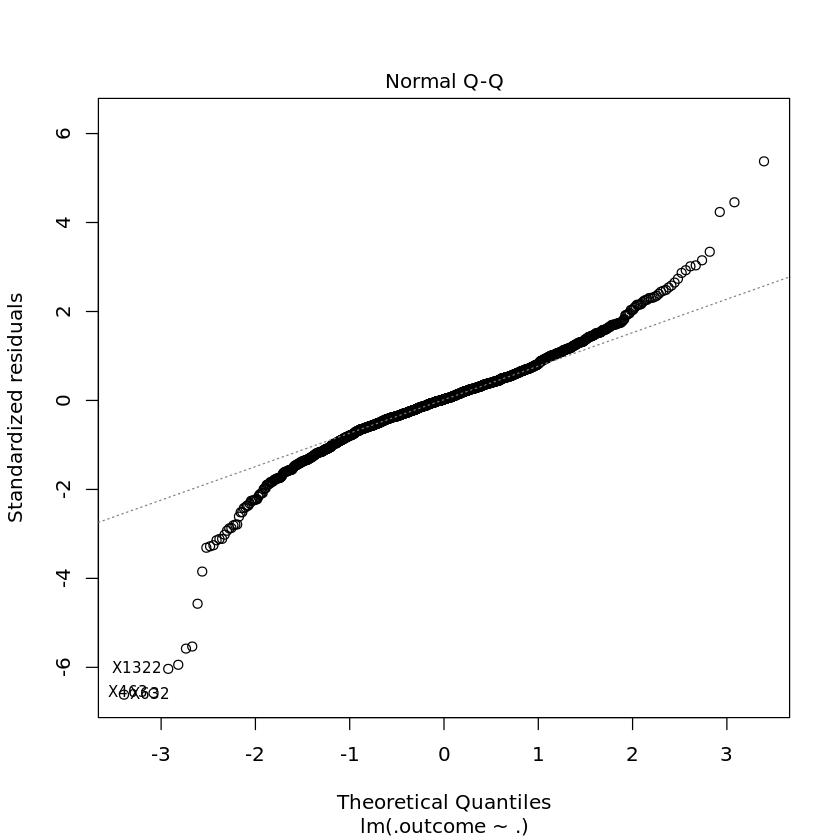

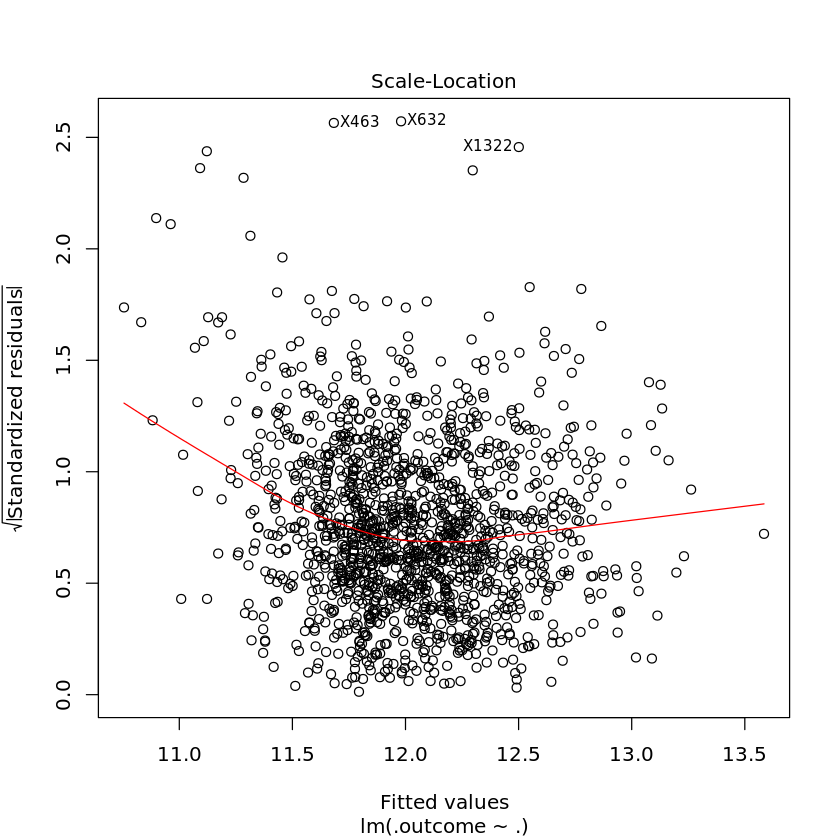

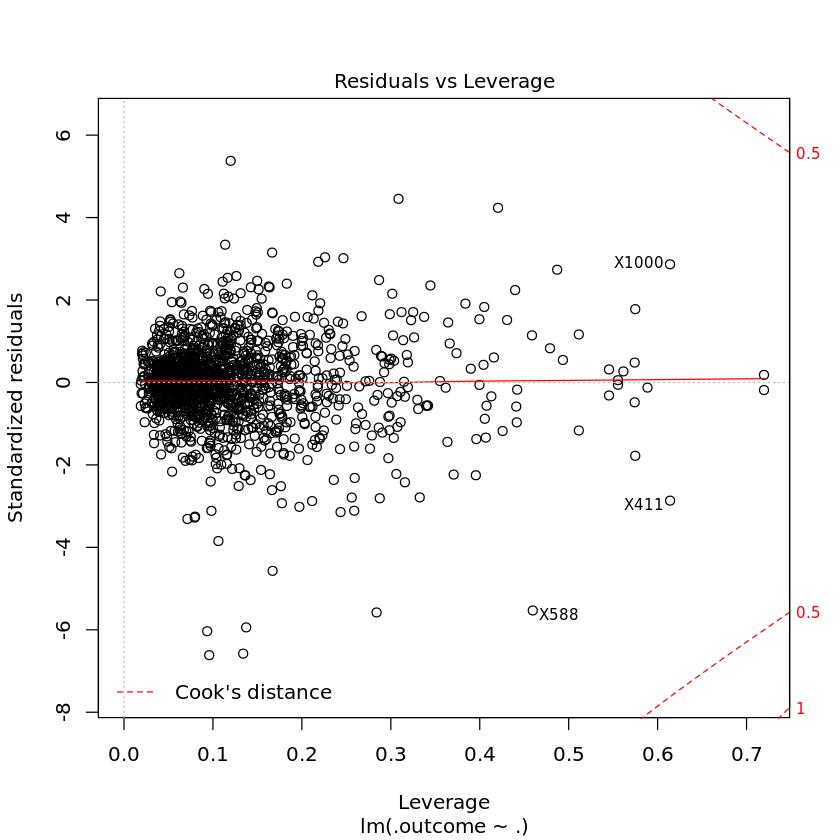

In [11]:
summary(ols_fit)
plot(ols_fit)

In [12]:
lm_cats <- train(SalePrice~TotBathrooms+SaleCondition+GarageArea+
                   KitchenQual+GrLivArea+TotalBsmtSF+OverallCond+OverallQual+
                   BldgType+Condition1+MSZoning,
                 data=train_df, 
                 method="lm",
                 trControl=controlParameter)
cats_fit <- lm_cats$finalModel


Call:
lm(formula = .outcome ~ ., data = dat)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.74901 -0.06420  0.00486  0.07715  0.47817 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           1.010e+01  5.431e-02 186.040  < 2e-16 ***
TotBathrooms          7.792e-02  6.256e-03  12.455  < 2e-16 ***
SaleConditionAdjLand  6.301e-02  6.808e-02   0.926 0.354835    
SaleConditionAlloca   1.256e-01  4.192e-02   2.995 0.002787 ** 
SaleConditionFamily   3.900e-02  3.237e-02   1.205 0.228364    
SaleConditionNormal   9.739e-02  1.397e-02   6.971 4.78e-12 ***
SaleConditionPartial  1.686e-01  1.898e-02   8.882  < 2e-16 ***
GarageArea            2.490e-04  2.138e-05  11.650  < 2e-16 ***
KitchenQualFa        -1.773e-01  2.916e-02  -6.080 1.54e-09 ***
KitchenQualGd        -6.928e-02  1.561e-02  -4.438 9.79e-06 ***
KitchenQualTA        -1.148e-01  1.792e-02  -6.409 1.99e-10 ***
GrLivArea             2.150e-04  9.975e-06  21.552  < 2e-16 ***
Tot

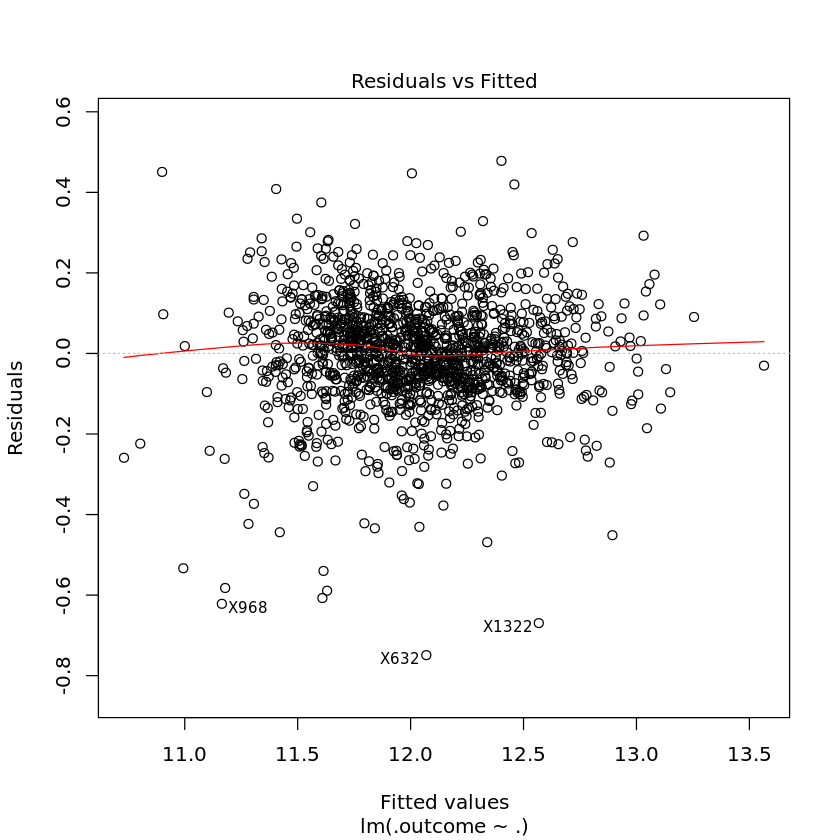

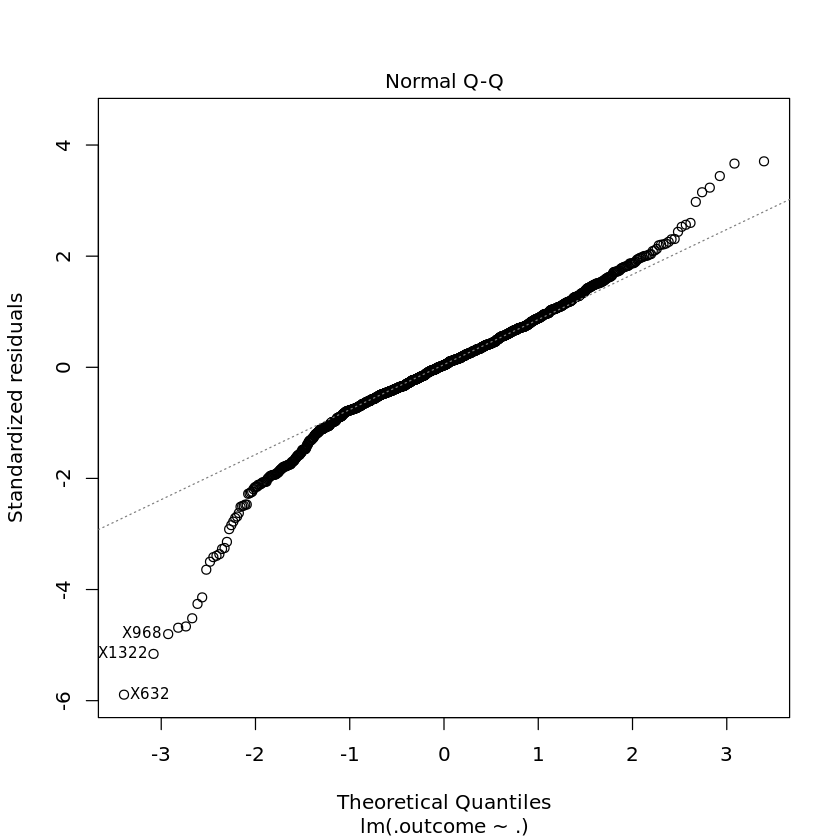

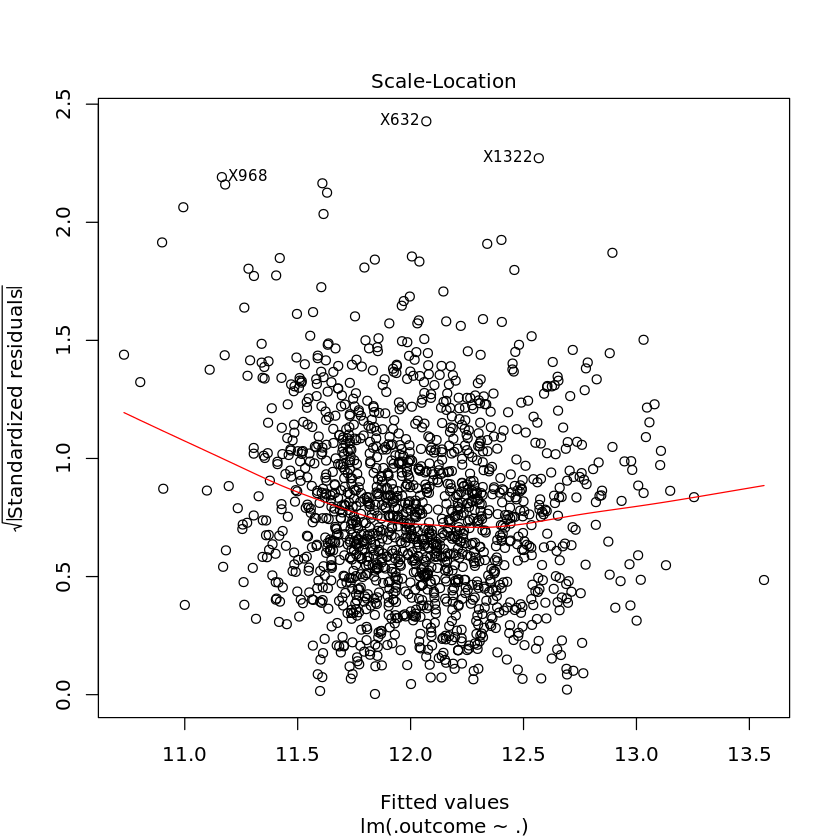

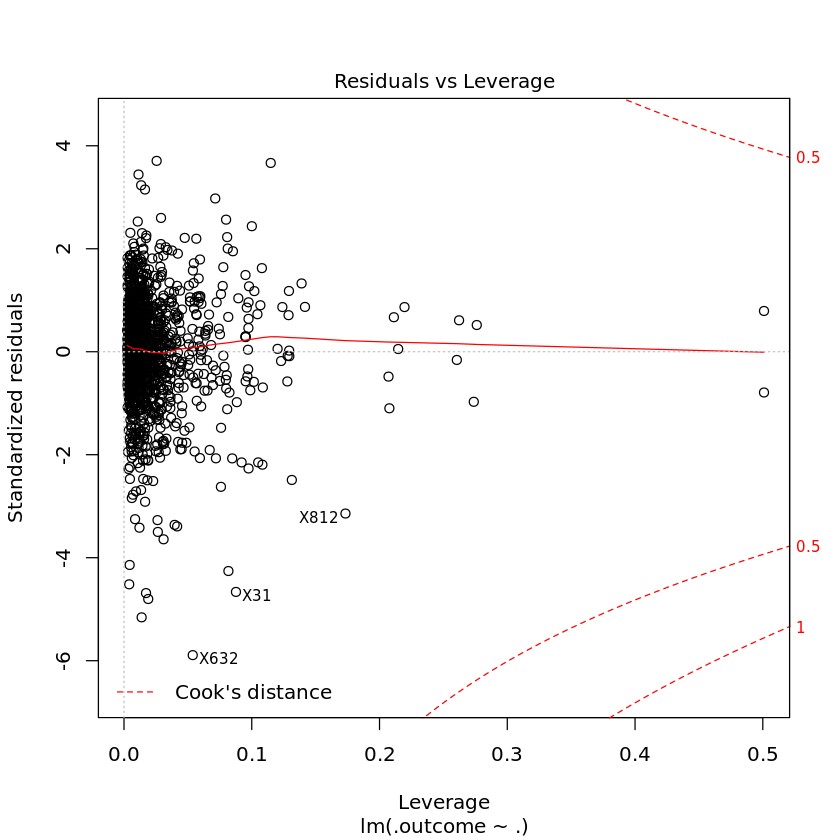

In [13]:
summary(cats_fit)
plot(cats_fit)

In [14]:
lm_forward <- train(SalePrice~., 
                    data=train_df,
                    method='leapForward',
                    trControl=controlParameter,
                    tuneGrid = expand.grid(nvmax = seq(1, 180, 1)))
fwd_fit <- lm_forward$finalModel

Reordering variables and trying again:
Reordering variables and trying again:
Reordering variables and trying again:
Reordering variables and trying again:
Reordering variables and trying again:
Reordering variables and trying again:
Reordering variables and trying again:
Reordering variables and trying again:
Reordering variables and trying again:
Reordering variables and trying again:
Reordering variables and trying again:


In [27]:
lm_forward$results[lm_forward$bestTune[1,1],]

,nvmax,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
166,166,0.1201752,0.9085474,0.08423964,0.008272609,0.02021026,0.005829622


In [ ]:
lm_backward <- train(SalePrice~., 
                     data=train_df,
                     method='leapBackward', 
                     trControl=controlParameter, 
                     tuneGrid = expand.grid(nvmax = seq(1, 180, 1)))
bwd_fit <- lm_backward$finalModel

In [ ]:
lambdas <- 10^seq(-1, -5, length = 100) # This NaNs after like 400
ridgeGrid <- expand.grid(alpha=0,lambda=lambdas)
lm_ridge <- train(SalePrice~., data=train_df, method = 'glmnet', trControl=controlParameter, tuneGrid=ridgeGrid)
ridge_fit <- lm_ridge$finalModel

In [ ]:
lambdas <- 10^seq(-2, -5, length = 300) # Opt lambda probably between .00001 and .01
lassoGrid <- expand.grid(alpha=1,lambda=lambdas)
lm_lasso <- train(SalePrice~., data=train_df, method = 'glmnet', trControl=controlParameter, tuneGrid=lassoGrid)
lasso_fit <- lm_lasso$finalModel

In [ ]:
elasGrid <- expand.grid(alpha=seq(0, 1, length=21),lambda=lambdas)
lm_elas <- train(SalePrice~., data=train_df, method = 'glmnet', trControl=controlParameter, tuneGrid=elasGrid)
elas_fit <- lm_elas$finalModel

In [ ]:
treeGrid <- expand.grid(cp=10^seq(-5,-3, length=101))
tree_cp <- train(SalePrice~.,
                 data=train_df,
                 method='rpart',
                 trControl=controlParameter,
                 tuneGrid=treeGrid)
# Zeroing in on the optimal value
treeFineGrid <- expand.grid(cp=seq(0.0002,.0004, length=101))
tree_cp <- train(SalePrice~.,
                 data=train_df,
                 method='rpart',
                 trControl=controlParameter,
                 tuneGrid=treeFineGrid)
tree_fit <- tree_cp$finalModel

In [ ]:
lm_ols_pred <- predict(lm_ols,train_df)
lm_cats_pred <- predict(lm_cats,train_df)
lm_forward_pred <- predict(lm_forward,train_df)
lm_backward_pred <- predict(lm_backward,train_df)
lm_lasso_pred <- predict(lm_lasso,train_df)
lm_ridge_pred <- predict(lm_ridge,train_df)
lm_elas_pred <- predict(lm_elas,train_df)
tree_cp_pred <- predict(tree_cp,train_df)

In [ ]:
ols_res <- ols_fit$residuals
cats_res <- cats_fit$residuals
fwd_res <- lm_forward_pred - train_df$SalePrice
bwd_res <- lm_backward_pred - train_df$SalePrice
lasso_res <- lm_lasso_pred - train_df$SalePrice
ridge_res <- lm_ridge_pred - train_df$SalePrice
elas_res <- lm_elas_pred - train_df$SalePrice
tree_res <- tree_cp_pred - train_df$SalePrice

In [ ]:
lm_rmsle <- rmsle(abs(lm_ols_pred), train_df$SalePrice)
lm_cats_rmsle <- rmsle(abs(lm_cats_pred), train_df$SalePrice)
lm_forward_rmsle <- rmsle(abs(lm_forward_pred), train_df$SalePrice) 
lm_backward_rmsle <- rmsle(abs(lm_backward_pred), train_df$SalePrice)
lm_lasso_rmsle <- rmsle(abs(lm_lasso_pred), train_df$SalePrice)
lm_ridge_rmsle <- rmsle(abs(lm_ridge_pred), train_df$SalePrice)
lm_elas_rmsle <- rmsle(abs(lm_elas_pred), train_df$SalePrice)
tree_cp_rmsle <- rmsle(abs(tree_cp_pred), train_df$SalePrice)

In [ ]:
rmsle_scores <- c(lm_rmsle, lm_cats_rmsle, lm_forward_rmsle,
                  lm_backward_rmsle, lm_ridge_rmsle, lm_lasso_rmsle,
                  lm_elas_rmsle, tree_cp_rmsle)
names(rmsle_scores) <- c("OLS_Full", "OLS_Manual", "OLS_Forward",
                         "OLS_Backward", "Ridge", "LASSO",
                         "Elastic","Tree_CP")

In [ ]:
best_lm_ols <- lm_ols$results[as.numeric(rownames(lm_ols$bestTune)),]
best_lm_cats <- lm_cats$results[as.numeric(rownames(lm_cats$bestTune)),]
best_lm_forward <- lm_forward$results[as.numeric(rownames(lm_forward$bestTune)),]
best_lm_backward <- lm_backward$results[as.numeric(rownames(lm_backward$bestTune)),]
best_lm_ridge <- lm_ridge$results[as.numeric(rownames(lm_ridge$bestTune)),]
best_lm_lasso <- lm_lasso$results[as.numeric(rownames(lm_lasso$bestTune)),]
best_lm_elastic <- lm_elas$results[as.numeric(rownames(lm_elas$bestTune)),]
best_tree_cp <- tree_cp$results[as.numeric(rownames(tree_cp$bestTune)),]

In [ ]:
cv_results <- data.frame(method = names(rmsle_scores), 
                         rmse = c(best_lm_ols['RMSE'][1,1],
                                  best_lm_cats['RMSE'][1,1],
                                  best_lm_forward['RMSE'][1,1],
                                  best_lm_backward['RMSE'][1,1],
                                  best_lm_ridge['RMSE'][1,1],
                                  best_lm_lasso['RMSE'][1,1],
                                  best_lm_elastic['RMSE'][1,1],
                                  best_tree_cp['RMSE'][1,1]),
                         rmse_sd = c(best_lm_ols['RMSESD'][1,1],
                                      best_lm_cats['RMSESD'][1,1],
                                      best_lm_forward['RMSESD'][1,1],
                                      best_lm_backward['RMSESD'][1,1],
                                      best_lm_ridge['RMSESD'][1,1],
                                      best_lm_lasso['RMSESD'][1,1],
                                      best_lm_elastic['RMSESD'][1,1],
                                      best_tree_cp['RMSESD'][1,1]))

In [ ]:
ggplot(cv_results, aes(x=method, y=rmse)) + 
         geom_dotplot(binaxis = 'y', stackdir = 'center') +
         geom_errorbar(aes(ymin=rmse-rmse_sd, ymax=rmse+rmse_sd), width=.2,
                                  position=position_dodge(.0)) +
         xlab("Method") +
         ylab("Cross-Validation RMSE")

In [ ]:
residuals <- data.frame(id = seq(1, length(ols_res)),
                        OLS_Full=ols_res,
                        OLS_Manual=cats_res,
                        OLS_Forward=fwd_res,
                        OLS_Backward=bwd_res,
                        Ridge=ridge_res,
                        LASSO=lasso_res,
                        Elastic=elas_res,
                        Tree=tree_res)
res_melt <- melt(residuals, id.vars = "id")

In [ ]:
ggplot(res_melt, aes(x=id, y=value, color=variable)) + 
  geom_point(alpha=0.3, size=0.75) +
  scale_colour_manual(values=c("red", "blue", "green", "orange",
                               "gray", "brown", "black", "purple")) +
  xlab("Observation Index") +
  ylab("Residual Value") +
  scale_fill_discrete(name = "Model")